In [1]:
import sys
print(sys.executable)

/usr/local/python/3.12.1/bin/python3


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve
from sklearn.model_selection import KFold

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
import time

In [7]:
import folium
from folium.plugins import HeatMap

In [8]:
from sklearn.feature_selection import RFE

### Reading data

In [9]:
df = pd.read_csv('data/rideshare_kaggle.csv')
df.head(3).T

,0,1,2
id,424553bb-7174-41ea-aeb4-fe06d4f4b9d7,4bd23055-6827-41c6-b23b-3c491f24e74d,981a3613-77af-4620-a42a-0c0866077d1e
timestamp,1544952607.89,1543284023.677,1543366822.198
hour,9,2,1
day,16,27,28
month,12,11,11
datetime,2018-12-16 09:30:07,2018-11-27 02:00:23,2018-11-28 01:00:22
timezone,America/New_York,America/New_York,America/New_York
source,Haymarket Square,Haymarket Square,Haymarket Square
destination,North Station,North Station,North Station
cab_type,Lyft,Lyft,Lyft


In [10]:
df.columns

Index(['id', 'timestamp', 'hour', 'day', 'month', 'datetime', 'timezone',
       'source', 'destination', 'cab_type', 'product_id', 'name', 'price',
       'distance', 'surge_multiplier', 'latitude', 'longitude', 'temperature',
       'apparentTemperature', 'short_summary', 'long_summary',
       'precipIntensity', 'precipProbability', 'humidity', 'windSpeed',
       'windGust', 'windGustTime', 'visibility', 'temperatureHigh',
       'temperatureHighTime', 'temperatureLow', 'temperatureLowTime',
       'apparentTemperatureHigh', 'apparentTemperatureHighTime',
       'apparentTemperatureLow', 'apparentTemperatureLowTime', 'icon',
       'dewPoint', 'pressure', 'windBearing', 'cloudCover', 'uvIndex',
       'visibility.1', 'ozone', 'sunriseTime', 'sunsetTime', 'moonPhase',
       'precipIntensityMax', 'uvIndexTime', 'temperatureMin',
       'temperatureMinTime', 'temperatureMax', 'temperatureMaxTime',
       'apparentTemperatureMin', 'apparentTemperatureMinTime',
       'apparentTemperat

In [12]:
drop_cols = ['timezone', 'product_id', 'short_summary', 'long_summary', 'windGustTime', 'temperatureHigh',
       'temperatureHighTime', 'temperatureLow', 'temperatureLowTime',
       'apparentTemperatureHigh', 'apparentTemperatureHighTime',
       'apparentTemperatureLow', 'apparentTemperatureLowTime', 'icon',
       'dewPoint', 'pressure', 'windBearing', 'cloudCover', 'uvIndex',
       'visibility.1', 'ozone', 'sunriseTime', 'sunsetTime', 'moonPhase',
       'precipIntensityMax', 'uvIndexTime', 'temperatureMin',
       'temperatureMinTime', 'temperatureMax', 'temperatureMaxTime',
       'apparentTemperatureMin', 'apparentTemperatureMinTime',
       'apparentTemperatureMax', 'apparentTemperatureMaxTime']

df2 = df.drop(drop_cols, axis=1)
df2.columns = df2.columns.str.replace(' ', '_').str.lower()
df2 = df2.set_index('id')

### Data split

In [13]:
random_seed = 42

In [14]:
df_full_train, df_test = train_test_split(df2, test_size=0.2, random_state=random_seed)
len(df_full_train), len(df_test)

(91744, 22936)

### EDA

In [16]:
df_full_train.sample(10)

,timestamp,hour,day,month,datetime,source,destination,cab_type,name,price,...,latitude,longitude,temperature,apparenttemperature,precipintensity,precipprobability,humidity,windspeed,windgust,visibility
id,,,,,,,,,,,,,,,,,,,,,
538908d2-969a-4607-b722-82383c9bce98,1.543445e+09,22,28,11,2018-11-28 22:44:08,Northeastern University,Financial District,Uber,UberXL,23.0,...,42.3647,-71.0542,40.43,34.59,0.0000,0.00,0.64,9.08,12.72,10.000
c52be751-4234-4262-a3ad-ee89e43e6f6d,1.543515e+09,18,29,11,2018-11-29 18:18:01,Fenway,Theatre District,Lyft,Lux,19.5,...,42.2148,-71.0330,43.65,37.25,0.0000,0.00,0.52,12.55,23.67,9.920
737f9737-fbb7-40c0-8c9a-df641ebe8222,1.543655e+09,8,1,12,2018-12-01 08:58:00,North End,North Station,Uber,Black SUV,26.0,...,42.2148,-71.0330,32.34,28.52,0.0000,0.00,0.81,3.95,3.95,9.949
562f8daf-744e-41d1-a6ff-b1b103199af0,1.544750e+09,1,14,12,2018-12-14 01:20:12,Beacon Hill,Haymarket Square,Uber,Black SUV,27.0,...,42.3398,-71.0892,30.64,30.64,0.0000,0.00,0.65,2.40,3.33,10.000
dae0498e-682b-4a39-a6b6-4553047ed2b2,1.543871e+09,21,3,12,2018-12-03 21:08:00,Beacon Hill,Northeastern University,Lyft,Lyft,9.0,...,42.3519,-71.0643,50.43,50.43,0.0000,0.00,0.50,7.21,10.33,9.972
ae30c203-91d5-4d25-95dc-7dd1e3970cc3,1.544921e+09,0,16,12,2018-12-16 00:50:13,Northeastern University,Back Bay,Uber,Taxi,NaN,...,42.3661,-71.0631,43.96,40.80,0.0000,0.00,0.68,5.48,8.73,10.000
1d20febc-1ea7-4295-90de-9a730a4b999f,1.543760e+09,14,2,12,2018-12-02 14:13:01,Back Bay,North End,Lyft,Lyft XL,16.5,...,42.3588,-71.0707,43.51,39.58,0.0832,1.00,0.96,6.60,8.47,2.644
3cb09309-b11f-4bf3-9374-9864250fb5ed,1.543860e+09,17,3,12,2018-12-03 17:52:57,Back Bay,North End,Lyft,Lux Black,27.5,...,42.3505,-71.1054,54.59,54.59,0.0000,0.00,0.63,9.43,15.07,10.000
b97c4b29-7739-4bad-a567-119eed3ecd0f,1.543783e+09,20,2,12,2018-12-02 20:33:00,North End,Back Bay,Lyft,Lyft XL,19.5,...,42.3505,-71.1054,49.70,49.70,0.0050,0.59,0.96,2.86,2.86,1.348


In [17]:
df_full_train.shape

(91744, 22)

### Missing values

In [18]:
df_full_train.isnull().sum()

timestamp                 0
hour                      0
day                       0
month                     0
datetime                  0
source                    0
destination               0
cab_type                  0
name                      0
price                  7213
distance                  0
surge_multiplier          1
latitude                  1
longitude                 1
temperature               1
apparenttemperature       1
precipintensity           1
precipprobability         1
humidity                  1
windspeed                 1
windgust                  1
visibility                1
dtype: int64

In [19]:
print(f'Percentage of missing values in price column {round(df_full_train.isnull().sum().sum()*100/df_full_train.shape[0],2)}%')

Percentage of missing values in price column 7.87%


In [20]:
df_full_train = df_full_train.dropna()

In [21]:
df_full_train.columns

Index(['timestamp', 'hour', 'day', 'month', 'datetime', 'source',
       'destination', 'cab_type', 'name', 'price', 'distance',
       'surge_multiplier', 'latitude', 'longitude', 'temperature',
       'apparenttemperature', 'precipintensity', 'precipprobability',
       'humidity', 'windspeed', 'windgust', 'visibility'],
      dtype='object')

In [22]:
df_full_train['timestamp'] = pd.to_datetime(df_full_train['timestamp'], unit='s')
df_full_train['datetime'] = pd.to_datetime(df_full_train['datetime'])

In [24]:
numerical_cols = ['price', 'distance', 'temperature', 'humidity', 'precipintensity', 'visibility']
cat_cols = ['source', 'destination', 'cab_type', 'name']
time_cols = ['hour', 'day']

In [25]:
def plot_univariate(df, list_vars):

    sns.set_style("whitegrid")
    plt.figure(figsize=(15, 10))
    for v in range(len(list_vars)):
        plt.subplot(3, 2, v+1)
        sns.histplot(df[list_vars[v]], bins=50, kde=False)
        plt.title(f'Distribution of {list_vars[v]}')
        plt.xlabel(f'{list_vars[v]}')
        plt.ylabel('Frequency')

    plt.tight_layout()
    plt.show()

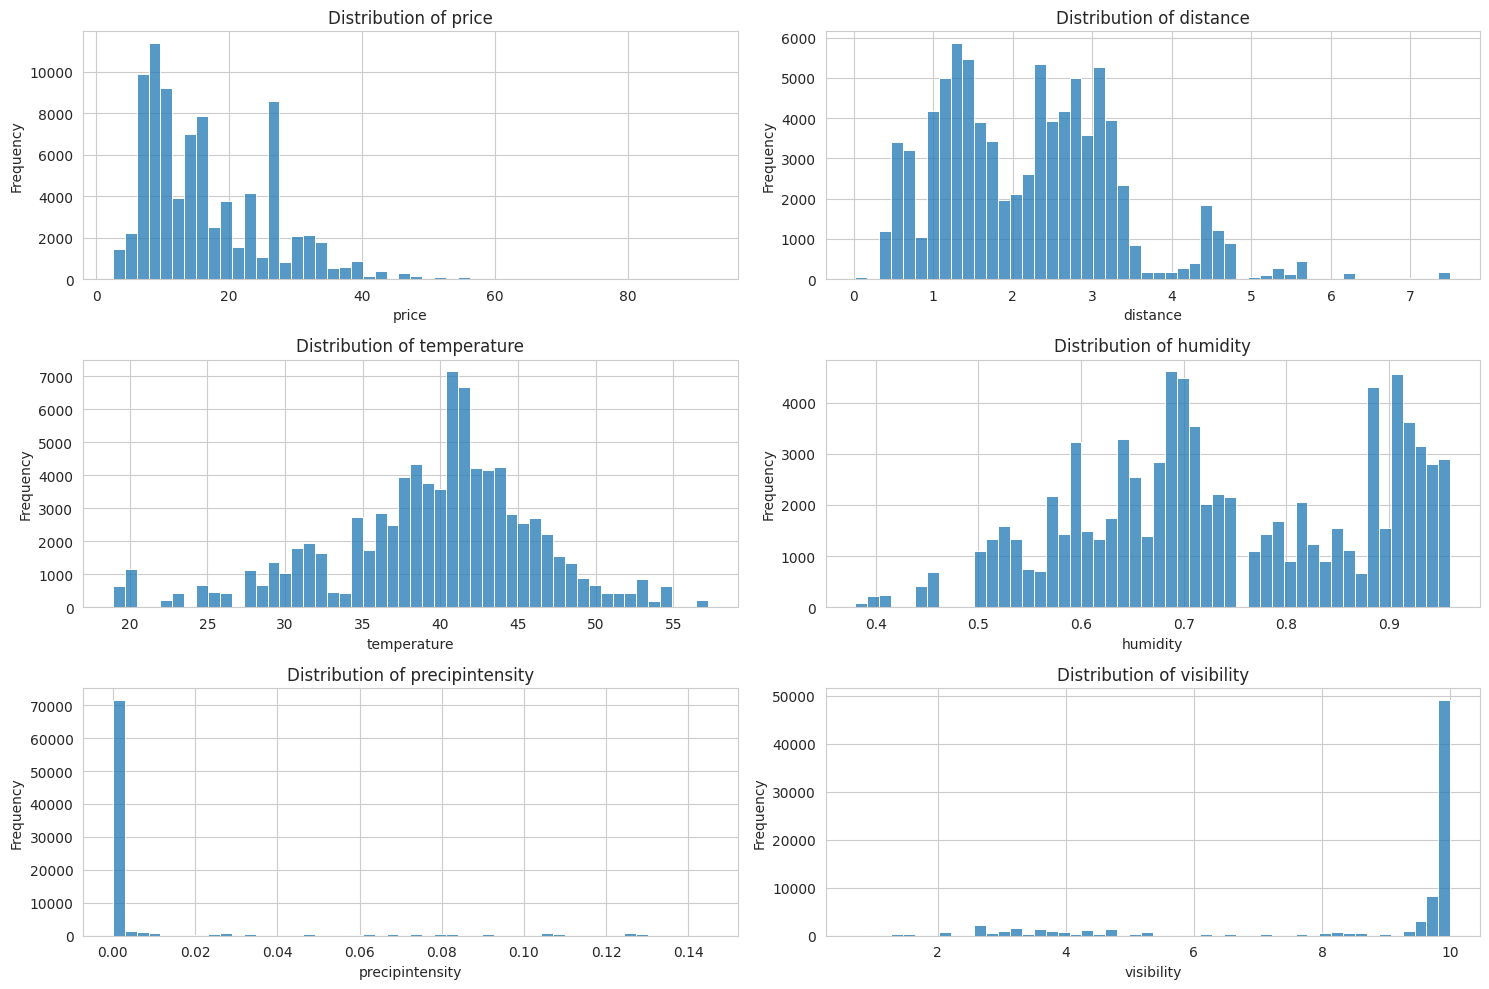

In [26]:
plot_univariate(df_full_train, numerical_cols)

In [27]:
def plot_categorical(df, list_vars, limit_cols=10):

    sns.set_style("whitegrid")
    plt.figure(figsize=(20, 15))
    for v in range(len(list_vars)):
        plt.subplot(2, 2, v+1)
        sns.countplot(data=df, y=list_vars[v], hue=list_vars[v],
                      order=df[list_vars[v]].value_counts().iloc[:limit_cols].index, palette='Spectral')
        plt.title(f'Count Distribution of {list_vars[v]}')
        plt.xlabel(f'{list_vars[v]}')
        plt.ylabel('Count')

    plt.tight_layout()
    plt.show()